# Senior Isolation Notebook


In [65]:
#importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from functools import reduce
from scipy.stats import ttest_ind
from scipy.interpolate import UnivariateSpline


#reading altarum csv files, formatting dataframes
altarum_loneliness = pd.read_csv('Data/altarum_loneliness_data.csv')
altarum_visitors = pd.read_csv('Data/altarum_visitors_per_week_data.csv')


altarum_loneliness = altarum_loneliness.set_index('Unnamed: 0')
altarum_visitors = altarum_visitors.set_index('Unnamed: 0')


#reading HRS data from .sas7bdat files, generated from original .da files given by HRS using SAS software
hrs12_lb = pd.read_sas('Data\h12lb_r.sas7bdat')
hrs12_n = pd.read_sas('Data\h12n_r.sas7bdat')
hrs12_prr = pd.read_sas('Data\h12pr_r.sas7bdat')

hrs14_lb = pd.read_sas('Data\h14lb_r.sas7bdat')
hrs14_n = pd.read_sas('Data\h14n_r.sas7bdat')
hrs14_prr = pd.read_sas('Data\h14pr_r.sas7bdat')

hrs16_lb = pd.read_sas('Data\h16lb_r.sas7bdat')
hrs16_n = pd.read_sas('Data\h16n_r.sas7bdat')
hrs16_prr = pd.read_sas('Data\h16pr_r.sas7bdat')

hrs18_lb = pd.read_sas('Data\h18lb_r.sas7bdat')
hrs18_n = pd.read_sas('Data\h18n_r.sas7bdat')
hrs18_prr = pd.read_sas('Data\h18pr_r.sas7bdat')
#NOTE: unlike the other HRS datasets, HRS 2018 data is 'PRELIMINARY' -- I accessed the data on 7/19/2021, ~12:00pm CST

#reading in data from NSHAP Round 3 (2015-2016); setting all missing values to pandas NaN values
nshap_ds1 = pd.read_csv('Data/36873-0001-Data.tsv', sep='\t', na_values=np.arange(-20, 0))

#setting basic styles and formatting for plots
%matplotlib inline 
plt.style.use("seaborn")

#ERROR: from pd.read_sas; known bug in python pandas; has no impact on the data

c:\users\razfyz\vs code projects\senior isolation report\isolation_report_venv\lib\site-packages\pandas\io\sas\sas7bdat.py:800: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._byte_chunk[jb, :].view(dtype=self.byte_order + "d")
c:\users\razfyz\vs code projects\senior isolation report\isolation_report_venv\lib\site-packages\pandas\io\sas\sas7bdat.py:809: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._string_chunk[js, :]


In [66]:
# defining functions for HRS data cleaning

hrs_nadrop = ['NX067_R', 'NLB020A', 'NLB020B', 'NLB020C', 'NN147', 'NN099']

hrs_relevant = ['HHID', 'PN', 'NX067_R', 'ages', 'NLB020A', 'NLB020B', 'NLB020C', 'lonely_yn', 'lonely_score',
                            'NN099', 'NN100', 'NN101', 'NN147', 'NN207']


#determine if lonely; respondent is lonely when 'NLB020A', 'NLB020B', or 'NLB020C' has value as < 3 (rationale below)
def det_lonely(df):
    lonely_yn_df = df.copy()
    lonely_yn_df['lonely_yn'] = False

    lonely_yn_df['lonely_yn'] = lonely_yn_df[(lonely_yn_df['NLB020A'] < 3) | (lonely_yn_df['NLB020B'] < 3) | 
                                          (lonely_yn_df['NLB020C'] < 3)]['lonely_yn'].map({False: True})
    lonely_yn_df['lonely_yn'] = lonely_yn_df['lonely_yn'].fillna(False)
    
    return lonely_yn_df


#data read in from HRS has non-integer identification numbers (HHID and PN); this function standardizes them as integers
def clean_id(df):
    cleaned_df =  df.copy()
    #using string slicing to clean HHID and PN identification numbers as clean integers
    cleaned_df[['HHID', 'PN']] = cleaned_df[['HHID', 'PN']].astype(str).applymap(lambda x: x[2:-1]).astype(int)
    return cleaned_df


#data from HRS only provides year of birth; this function uses survey year and birth year to calculate age in new column 'ages'
def det_age(df, year):
    aged_df = df.copy()
    aged_df['ages'] = aged_df['NX067_R']
    aged_df.ages = aged_df.loc[:, 'ages'].apply(lambda x: x * -1 + year)
    return aged_df

#scoring loneliness: reverse scored such that max score (most lonely) = 9; min score (least lonely) = 3 (UCLA 3 Item)
def score_loneliness(df):
    scored_df = df.copy()
    scored_df['lonely_score'] = scored_df.apply(lambda x: 12 - (x['NLB020A'] + x['NLB020B'] + x['NLB020C']), axis=1)
    return scored_df


#creates merged HRS dataframe from raw PR-R, LB, and N datafiles; determines if lonely (y/n), determines age, and cleans ids;
#drops rows without necessary data; cleans N100 column; scores loneliness; filters out columns with unneeded information
def merge_hrs(df1, df2, df3, int_year):
    merged_df = reduce(lambda  left,right: pd.merge(left,right, on=['HHID', 'PN'], how='outer'), [df1, df2, df3])
    
    #dropping participants with ANY blank values within the necessary fields
    merged_df_drop = merged_df.dropna(axis='index', how='any', subset=hrs_nadrop)
    
    #determine if 'lonely' according to definition, add to new column
    merged_lonely_yn = det_lonely(merged_df_drop) 
    
    #clean HHID and PN
    merged_cid = clean_id(merged_lonely_yn)
    
    #determine age from birth year and year of interview, add to new column
    merged_aged = det_age(merged_cid, int_year)
    
    #set NaN values in N100 (number of nights spent in hospital) to zero; HRS data codebook implies NaN values mean 0 nights
    merged_aged['NN100'] = merged_aged['NN100'].fillna(0)
    
        
    #determine reverse-scored loneliness score, add to new column
    merged_scored = score_loneliness(merged_aged)
    
    #get only relevent columns in final merged df
    merged_final = merged_scored[hrs_relevant]

    return merged_final

In [67]:
#when first creating this project, I used the 2012 HRS data to explore the data; in order to apply the same functions I used 
#on the HRS 2012 data on the HRS 2014, HRS 2016, and HRS 2018 data, I had to rename columns on the more recent datasets to the 
#corresponding columns in the 2012 dataset.

#defining function that will take df and a dictionary to rename columns in the dataframe
def rename_col(df, dictionary):
    renamed_df = df.copy()
    renamed_df.rename(dictionary, axis=1, inplace=True)
    return renamed_df

#creating python dictionaries to connect relevant columns to the corresponding HRS 2012 columns
hrs14_lb_rename = {'OLB019A':'NLB020A', 'OLB019B':'NLB020B', 'OLB019C':'NLB020C'}
hrs14_n_rename = {'ON099':'NN099', 'ON100':'NN100', 'ON101':'NN101', 'ON147':'NN147', 'ON207':'NN207'}
hrs14_prr_rename = {'OX067_R':'NX067_R'}

hrs16_lb_rename = {'PLB019A':'NLB020A', 'PLB019B':'NLB020B', 'PLB019C':'NLB020C'}
hrs16_n_rename = {'PN099':'NN099', 'PN100':'NN100', 'PN101':'NN101', 'PN147':'NN147', 'PN207':'NN207'}
hrs16_prr_rename = {'PX067_R':'NX067_R'}

hrs18_lb_rename = {'QLB019A':'NLB020A', 'QLB019B':'NLB020B', 'QLB019C':'NLB020C'}
hrs18_n_rename = {'QN099':'NN099', 'QN100':'NN100', 'QN101':'NN101', 'QN147':'NN147', 'QN207':'NN207'}
hrs18_prr_rename = {'QX067_R':'NX067_R'}

hrs14_lbr = rename_col(hrs14_lb, hrs14_lb_rename)
hrs14_nr = rename_col(hrs14_n, hrs14_n_rename)
hrs14_prrr = rename_col(hrs14_prr, hrs14_prr_rename)

hrs16_lbr = rename_col(hrs16_lb, hrs16_lb_rename)
hrs16_nr = rename_col(hrs16_n, hrs16_n_rename)
hrs16_prrr = rename_col(hrs16_prr, hrs16_prr_rename)

hrs18_lbr = rename_col(hrs18_lb, hrs18_lb_rename)
hrs18_nr = rename_col(hrs18_n, hrs18_n_rename)
hrs18_prrr = rename_col(hrs18_prr, hrs18_prr_rename)

In [68]:
#creating merged HRS dataframes: cleaned and standarized for analysis 
hrs12m = merge_hrs(hrs12_lb, hrs12_n, hrs12_prr, 2012)
hrs14m = merge_hrs(hrs14_lbr, hrs14_nr, hrs14_prrr, 2014)
hrs16m = merge_hrs(hrs16_lbr, hrs16_nr, hrs16_prrr, 2016)
hrs18m = merge_hrs(hrs18_lbr, hrs18_nr, hrs18_prrr, 2018)

In [69]:
#Defining functions for NSHAP data cleaning

relevant_nshap_columns = ['ID', 'AGE', 'COMPANION2', 'LEFTOUT2', 'ISOLATED2', 'lonely_score', 'FLTTENS', 'FRIGHT', 
                            'WORRY', 'RELAXED', 'BUTRFLY', 'RESTLES', 'PANIC', 'anxiety_score', 'NOTEAT', 'FLTDEP', 
                            'FLTEFF', 'NOSLEEP', 'WASHAPY', 'WASLONLY', 'UNFRIEND', 'ENJLIFE', 'FLTSAD', 'DISLIKD', 
                            'NOTGETGO',  'depression_score', 'UNCNTRL', 'CONFIDNT', 'GOMYWAY', 'PILEDIFF', 'pstress_score']

dropna_nshap_columns = ['ID', 'AGE', 'COMPANION2', 'LEFTOUT2', 'ISOLATED2', 'FLTTENS', 'FRIGHT', 
                            'WORRY', 'RELAXED', 'BUTRFLY', 'RESTLES', 'PANIC',  'NOTEAT', 'FLTDEP', 
                            'FLTEFF', 'NOSLEEP', 'WASHAPY', 'WASLONLY', 'UNFRIEND', 'ENJLIFE',
                            'FLTSAD', 'DISLIKD', 'NOTGETGO', 'UNCNTRL', 'CONFIDNT', 'GOMYWAY', 'PILEDIFF']

#scoring loneliness: scored such that max score (most lonely) = 9; min score (least lonely) = 0 (UCLA 3 Item)
def nshap_score_loneliness(df):
    scored_df = df.copy()
    scored_df['lonely_score'] = scored_df.apply(lambda x: x['COMPANION2'] + x['LEFTOUT2'] + x['ISOLATED2'], axis=1)
    return scored_df


#scoring anxiety: scored such that max score (most anxious) = 28; min score (least anxious) = 0 
#(Hospital Anxiety and Depression Scale; HADS)
def nshap_score_anxiety(df):
    scored_df = df.copy()
    scored_df['anxiety_score'] = scored_df.apply(lambda x: x['FLTTENS'] + x['FRIGHT'] + x['WORRY'] + 
                                x['RELAXED'] + x['BUTRFLY'] + x['RESTLES'] + x['PANIC'], axis=1)
    return scored_df

#scoring depression: scored such that max score (most depressed) = 44; min score (least depressed) = 0 
#(Center for Epidemiological Studies-Depression Minus Loneliness; CES-D)
def nshap_score_depression(df):
    scored_df = df.copy()
    scored_df['depression_score'] = scored_df.apply(lambda x: x['NOTEAT'] + x['FLTDEP'] + x['FLTEFF'] + 
                                x['NOSLEEP'] + x['WASHAPY'] + x['WASLONLY'] + x['UNFRIEND'] + x['ENJLIFE'] +
                                x['FLTSAD'] + x['DISLIKD'] + x['NOTGETGO'], axis=1)
    return scored_df

#scoring percieved stress: scored such that max score (most percievd stress) = 16; min score (least percieved stress) = 0 
#(Perceived Stress Scale- 4 Item; PSS)
def nshap_score_pstress(df):
    scored_df = df.copy()
    scored_df['pstress_score'] = scored_df.apply(lambda x: x['UNCNTRL'] + (4 - x['CONFIDNT']) + (4 - x['GOMYWAY']) + 
                                                 x['PILEDIFF'], axis=1)
    return scored_df

In [70]:
#putting raw NSHAP data through cleaning functions to generate cleaned final dataframe for analysis

#dropping participants with ANY blank values within the necessary fields
nshap_clean = nshap_ds1.dropna(axis='index', how='any', subset=dropna_nshap_columns)

#putting nshap dataframe through the functions taht determine loneliness, anxiety, depression, and percieved stress scores
nshap_lscore = nshap_score_loneliness(nshap_clean)
nshap_ascore = nshap_score_anxiety(nshap_lscore)
nshap_dscore = nshap_score_depression(nshap_ascore)
nshap_psscore = nshap_score_pstress(nshap_dscore)

#getting a final NSHAP dataframe with only relevant columns
nshap_f = nshap_psscore[relevant_nshap_columns]

HRS: Loneliness as function of age

In [71]:
#applying smoothing spline to data using UnivariateSpline function in SciPy
def apply_spline(df, upper_lim): 
    dfc = df.copy()
    #arbitrarily chose age of 48 years as the lower cut off; chose upper limit depending survey year
    dfc_c = dfc[(dfc['ages'] >= 48) & (dfc['ages'] <= upper_lim)]

    dfc_scores = dfc_c.groupby('ages').lonely_score.mean()
    dfc_ages = dfc_scores.index
    spl = UnivariateSpline(dfc_ages, dfc_scores)
    return [dfc_ages, dfc_scores, spl]

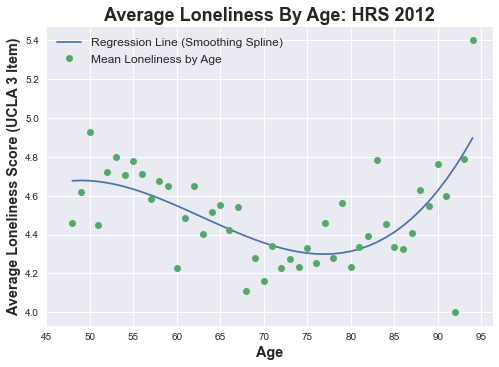

In [72]:
#using apply_spline() to get spline data to plot; upper limit of 94 because in 2012 dataset bc very few (< 10) respondents above
#94, given the way I filtered the data
hrs12_splined = apply_spline(hrs12m, 94)
hrs12_rawx = hrs12_splined[0]
hrs12_rawy = hrs12_splined[1]
hrs12_spline = hrs12_splined[2]

#rendering plot with regression line and actual points
plt.title("Average Loneliness By Age: HRS 2012", fontsize=18, fontweight='bold')
plt.plot(hrs12_rawx, hrs12_spline(hrs12_rawx), label='Regression Line (Smoothing Spline)')
plt.plot(hrs12_rawx, hrs12_rawy, 'o', label='Mean Loneliness by Age')

plt.xlabel('Age', fontsize='x-large', fontweight='bold')
plt.ylabel('Average Loneliness Score (UCLA 3 Item)', fontsize='x-large', fontweight='bold')
plt.xticks(ticks=np.arange(45, 100, 5))

plt.legend(fontsize='large')
plt.tight_layout
plt.show()

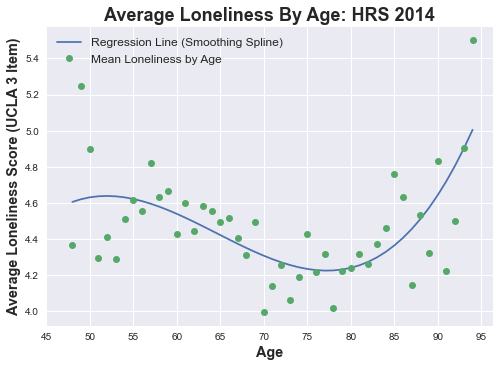

In [86]:
hrs14_splined = apply_spline(hrs14m, 94)
hrs14_rawx = hrs14_splined[0]
hrs14_rawy = hrs14_splined[1]
hrs14_spline = hrs14_splined[2]

#rendering plot with regression line and actual points
plt.title("Average Loneliness By Age: HRS 2014", fontsize=18, fontweight='bold')
plt.plot(hrs14_rawx, hrs14_spline(hrs14_rawx), label='Regression Line (Smoothing Spline)')
plt.plot(hrs14_rawx, hrs14_rawy, 'o', label='Mean Loneliness by Age')

plt.xlabel('Age', fontsize='x-large', fontweight='bold')
plt.ylabel('Average Loneliness Score (UCLA 3 Item)', fontsize='x-large', fontweight='bold')
plt.xticks(ticks=np.arange(45, 100, 5))

plt.legend(fontsize='large')
plt.tight_layout
plt.show()

In [89]:
hrs14m.groupby('ages').size().tail(60)

ages
42.0       6
43.0       6
44.0      11
45.0       7
46.0      10
47.0      20
48.0      19
49.0      16
50.0      29
51.0      44
52.0      51
53.0      62
54.0      94
55.0     246
56.0     244
57.0     269
58.0     251
59.0     259
60.0     231
61.0     251
62.0     272
63.0     243
64.0     264
65.0     250
66.0     251
67.0     187
68.0     197
69.0     138
70.0     160
71.0     191
72.0     196
73.0     259
74.0     244
75.0     199
76.0     210
77.0     220
78.0     186
79.0     181
80.0     164
81.0     138
82.0     150
83.0     132
84.0     104
85.0      79
86.0     101
87.0      77
88.0      77
89.0      56
90.0      48
91.0      36
92.0      30
93.0      31
94.0      20
95.0      18
96.0      10
97.0       5
98.0       5
100.0      1
101.0      1
105.0      1
dtype: int64

Altarum Survey: Loneliness increase after restrictions implemented

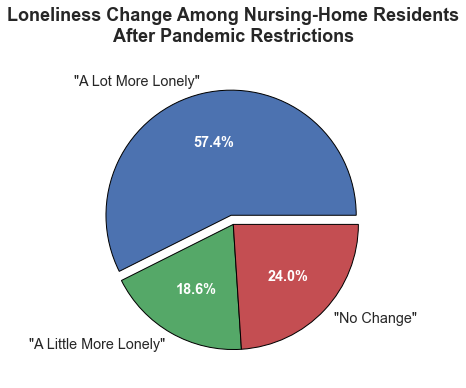

In [73]:
#manipulating dataframe to input into 'plt.pie'
alt_loneliness_series = altarum_loneliness.unstack(1)

#setting labels for each section of the pie chart
labels = ["\"A Lot More Lonely\"", "\"A Little More Lonely\"", "\"No Change\""]

#parameters for explode
explode = [0.075, 0, 0]

#rendering the pie chart with styling
plt.title("Loneliness Change Among Nursing-Home Residents\nAfter Pandemic Restrictions\n", fontsize=18, fontweight='bold')
patches, texts, pcts = plt.pie(alt_loneliness_series, labels=labels, wedgeprops={'edgecolor': 'black', 'linewidth': 1}, 
                            autopct='%1.1f%%', explode=explode, textprops={'size': 'x-large'})
plt.setp(pcts, color='white', fontweight='bold')

plt.tight_layout()
plt.show()

Altarum Survey: Visitors before and after restrictions implemented

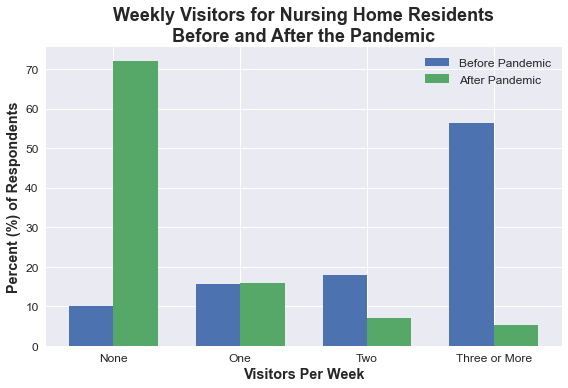

In [74]:
# %matplotlib notebook

#manipulating dataframe to create two series with data for the double bar graph
visitors_pre_rest = altarum_visitors.iloc[0]
visitors_post_rest = altarum_visitors.iloc[1]

#set manual bar width and 'x_indexes' to make offsets possible
x_indexes = np.arange(len(visitors_pre_rest))
width = 0.35

#rendering double bar graph with styling
plt.title("Weekly Visitors for Nursing Home Residents\nBefore and After the Pandemic", 
                            fontsize=18, fontweight='bold')
plt.bar(x_indexes - width/2, visitors_pre_rest, width=width, label='Before Pandemic')
plt.bar(x_indexes + width/2, visitors_post_rest, width=width, label='After Pandemic')

#NOTE: add 'edgecolor='black', linewidth=1' to plt.bar if you want to add borders to each of the bars

plt.xlabel('Visitors Per Week', fontsize='x-large', fontweight='bold')
plt.ylabel('Percent (%) of Respondents', fontsize='x-large', fontweight='bold')
plt.xticks(ticks=x_indexes, labels=['None', 'One', 'Two', 'Three or More'], fontsize='large')
plt.yticks(fontsize='large')

plt.legend(fontsize='large')
plt.tight_layout()
plt.show()

NSHAP: Correlations of loneliness with depression and anxiety among elderly 

In [75]:
#indexing into nshap_f dataframe generated above to get data for used in plots below
nshap_lscorex = nshap_f['lonely_score']
nshap_ascorey = nshap_f['anxiety_score']
nshap_dscorey = nshap_f['depression_score']
nshap_psscorey = nshap_f['pstress_score']

c:\users\razfyz\vs code projects\senior isolation report\isolation_report_venv\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:          anxiety_score   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     335.4
Date:                Mon, 19 Jul 2021   Prob (F-statistic):           3.63e-71
Time:                        16:34:31   Log-Likelihood:                -7736.3
No. Observations:                3053   AIC:                         1.548e+04
Df Residuals:                    3051   BIC:                         1.549e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           11.4837      0.091    126.218   

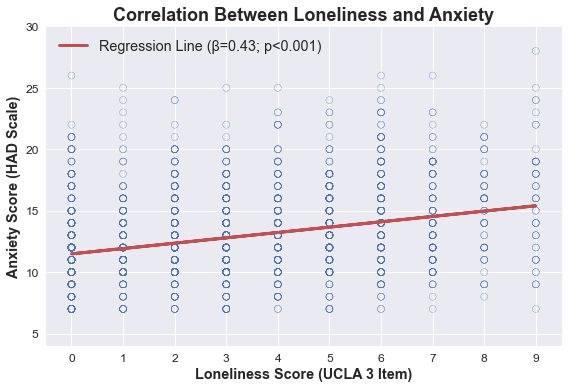

In [76]:
#correlating loneliness score and anxiety score
results = sm.OLS(nshap_ascorey,sm.add_constant(nshap_lscorex)).fit()

#printing linear regression analysis summary
print(results.summary())

#rendering scatter plot with data points and regression line
plt.scatter(nshap_lscorex, nshap_ascorey, facecolors='none', edgecolors='#4c72b0', marker='o')

plt.plot(nshap_lscorex, nshap_lscorex*results.params[1] + results.params[0], label='Regression Line (β=0.43; p<0.001)',
        linewidth=3, color='#c44e52')

plt.title("Correlation Between Loneliness and Anxiety", fontsize=18, fontweight='bold')
plt.xlabel('Loneliness Score (UCLA 3 Item)', fontsize='x-large', fontweight='bold')
plt.ylabel('Anxiety Score (HAD Scale)', fontsize='x-large', fontweight='bold')

plt.xticks(ticks=np.arange(0,10), fontsize='large')
plt.yticks(ticks=np.arange(5, 35, 5), fontsize='large')
plt.ylim(4, 30)
plt.xlim(-.5, 9.5)


plt.legend(fontsize='x-large', loc='upper left')
plt.tight_layout()
plt.show()

c:\users\razfyz\vs code projects\senior isolation report\isolation_report_venv\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:       depression_score   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     568.7
Date:                Mon, 19 Jul 2021   Prob (F-statistic):          2.12e-115
Time:                        16:34:32   Log-Likelihood:                -8184.0
No. Observations:                3053   AIC:                         1.637e+04
Df Residuals:                    3051   BIC:                         1.638e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           18.9596      0.105    179.962   

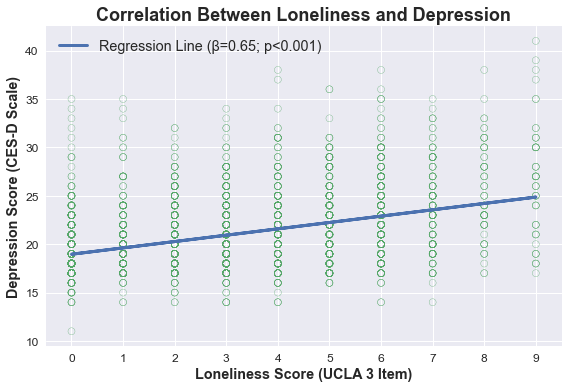

In [77]:
#correlating loneliness score and depression score
results = sm.OLS(nshap_dscorey,sm.add_constant(nshap_lscorex)).fit()

#printing linear regression analysis summary
print(results.summary())

#rendering scatter plot with data points and regression line
plt.scatter(nshap_lscorex, nshap_dscorey, facecolors='none', edgecolors='#55a868', marker='o')

plt.plot(nshap_lscorex, nshap_lscorex*results.params[1] + results.params[0], label='Regression Line (β=0.65; p<0.001)', 
         color='#4c72b0', linewidth=3)

plt.xticks(ticks=np.arange(0,10))
plt.xlim(-.5, 10)

plt.title("Correlation Between Loneliness and Depression", fontsize=18, fontweight='bold')
plt.xlabel('Loneliness Score (UCLA 3 Item)', fontsize='x-large', fontweight='bold')
plt.ylabel('Depression Score (CES-D Scale)', fontsize='x-large', fontweight='bold')
plt.xticks(ticks=np.arange(0,11), fontsize='large')
plt.yticks(fontsize='large')
plt.xlim(-.5, 9.5)


plt.legend(fontsize='x-large')
plt.tight_layout()
plt.show()

c:\users\razfyz\vs code projects\senior isolation report\isolation_report_venv\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:          pstress_score   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     313.7
Date:                Mon, 19 Jul 2021   Prob (F-statistic):           6.85e-67
Time:                        16:34:32   Log-Likelihood:                -7042.6
No. Observations:                3053   AIC:                         1.409e+04
Df Residuals:                    3051   BIC:                         1.410e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.6645      0.072     50.551   

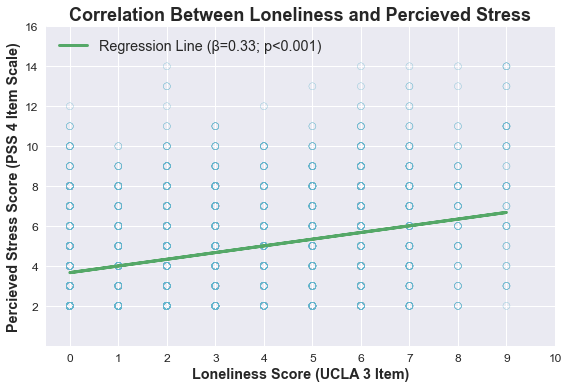

In [78]:
#correlating loneliness score and percieved stress score
results = sm.OLS(nshap_psscorey,sm.add_constant(nshap_lscorex)).fit()

#printing linear regression analysis summary
print(results.summary())

#rendering scatter plot with data points and regression line
plt.scatter(nshap_lscorex, nshap_psscorey, facecolors='none', edgecolors='#64b5cd', marker='o')

plt.plot(nshap_lscorex, nshap_lscorex*results.params[1] + results.params[0], label='Regression Line (β=0.33; p<0.001)',
        linewidth=3, color='#55a868')

plt.xticks(ticks=np.arange(0,11))
plt.xlim(-.5, 10)

plt.title("Correlation Between Loneliness and Percieved Stress", fontsize=18, fontweight='bold')
plt.xlabel('Loneliness Score (UCLA 3 Item)', fontsize='x-large', fontweight='bold')
plt.ylabel('Percieved Stress Score (PSS 4 Item Scale)', fontsize='x-large', fontweight='bold')

plt.xticks(ticks=np.arange(0,11), fontsize='large')
plt.yticks(np.arange(2, 17, 2), fontsize='large')
plt.xlim(-.5, 10)
plt.ylim(0, 16)

plt.legend(fontsize='x-large', loc='upper left')
plt.tight_layout()
plt.show()

HRS: Increased number of physician visits (and hospitalizations) when lonely

In [79]:
#defining function that determines the number of visits (to physician or hospital) to be plotted; does t-test on difference
#to determine significance

#when using this function, input column argument within single quotations; ex: hrs_visits(hrs12mc, 'NN147', 998, 999)
def hrs_visits(df, column, DK_val, RF_val):
    dfc = df.copy()
    
    #numeric DK_val and RF_val indicate "Don't Know" and "Refused [to answer]" respectively in the data; drop those values
    dfc_clean = dfc[(dfc[column] != DK_val) & (dfc[column] != RF_val)]
    
    #setting values such that values over 99th percentile are replaced with the 99th percentile value
    #this is done in order to control for the disproportionately large outliers within the raw data (ex: '900' physician visits)
    dfc_clean.loc[dfc_clean[column] >= dfc_clean[column].quantile(.99), column] = dfc_clean[column].quantile(.99)
    
    #run a t-test to determine whether the differences between the means of the data are significantly different
    lonely_y = dfc_clean[dfc_clean.lonely_yn == True][column]
    lonely_n = dfc_clean[dfc_clean.lonely_yn == False][column]
    ttest = ttest_ind(lonely_y, lonely_n)

    #return descriptive statistics about the loneliness (count, mean, standard deviation, quarentiles, etc) to be used in plots
    #also return t-test output which includes the t-statistic and p-value (to determine statistical significance)
    lonely_y_describe = lonely_y.describe()
    lonely_n_describe = lonely_n.describe()
    return [lonely_y_describe, lonely_n_describe, ttest]

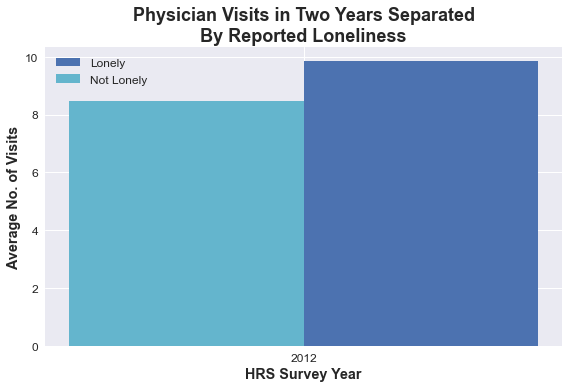

In [84]:
#number of doctor visits separated by reported loneliness

#putting data through hrs_visits function to find number of doctor visits
hrs12_dvisits = hrs_visits(hrs12m, 'NN147', 998, 999)

#create empty lists to be filled with mean number of visits, separated by whether reported feeling lonely or not
lonely_dvisits = []
nlonely_dvisits = []

#appending data from hrs_visits onto lonely_dvisits and nlonely_dvisits to plot
lonely_dvisits.append(hrs12_dvisits[0]['mean'])

nlonely_dvisits.append(hrs12_dvisits[1]['mean'])

#set manual bar width and 'x_indexes' to make offsets possible
x_indexes = np.arange(len(lonely_dvisits))
width = 0.35

#rendering double bar graph with styling
plt.title("Physician Visits in Two Years Separated\nBy Reported Loneliness", fontsize=18, fontweight='bold')
plt.bar(x_indexes + width/2, lonely_dvisits, width=width, label='Lonely')
plt.bar(x_indexes - width/2, nlonely_dvisits, width=width, label='Not Lonely', color='#64b5cd')

#NOTE: add 'edgecolor='black', linewidth=1' to plt.bar if you want to add borders to each of the bars

plt.xlabel('HRS Survey Year', fontsize='x-large', fontweight='bold')
plt.ylabel('Average No. of Visits', fontsize='x-large', fontweight='bold')
plt.xticks(ticks=x_indexes, labels=['2012'], fontsize='large')
plt.yticks(fontsize='large')

plt.legend(fontsize='large')
plt.tight_layout()
plt.show()

In [81]:
#printing t-test resutlts for doctor visits
print(hrs12_dvisits[2])

Ttest_indResult(statistic=4.682497433461286, pvalue=2.889214093673012e-06)


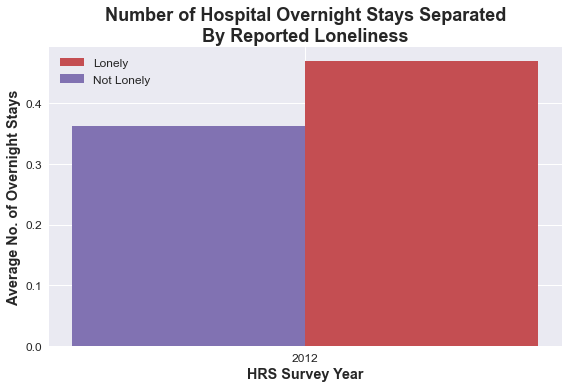

In [82]:
#number of hospital overnight stays separated by reported loneliness

#create empty lists to be filled with mean number of stays, separated by whether reported feeling lonely or not
lonely_hstays = []
nlonely_hstays = []

#putting data through hrs_visits function to find number of hospital stays
hrs12_hstays = hrs_visits(hrs12m, 'NN100', 98, 99)

#appending data from hrs_visits onto lonely_dvisits and nlonely_dvisits to plot
lonely_hstays.append(hrs12_hstays[0]['mean'])

nlonely_hstays.append(hrs12_hstays[1]['mean'])

#set manual bar width and 'x_indexes' to make offsets possible
x_indexes = np.arange(len(lonely_hstays))
width = 0.35

#rendering double bar graph with styling
plt.title("Number of Hospital Overnight Stays Separated\nBy Reported Loneliness", 
                            fontsize=18, fontweight='bold')
plt.bar(x_indexes + width/2, lonely_hstays, width=width, label='Lonely', color='#c44e52')
plt.bar(x_indexes - width/2, nlonely_hstays, width=width, label='Not Lonely', color='#8172b2')

#NOTE: add 'edgecolor='black', linewidth=1' to plt.bar if you want to add borders to each of the bars

plt.xlabel('HRS Survey Year', fontsize='x-large', fontweight='bold')
plt.ylabel('Average No. of Overnight Stays', fontsize='x-large', fontweight='bold')
plt.xticks(ticks=x_indexes, labels=['2012'], fontsize='large')
plt.yticks(fontsize='large')

plt.legend(fontsize='large')
plt.tight_layout()
plt.show()

In [83]:
#printing t-test results for hospital stays
print(hrs12_hstays[2])

Ttest_indResult(statistic=4.760213552368963, pvalue=1.9722314122990534e-06)
